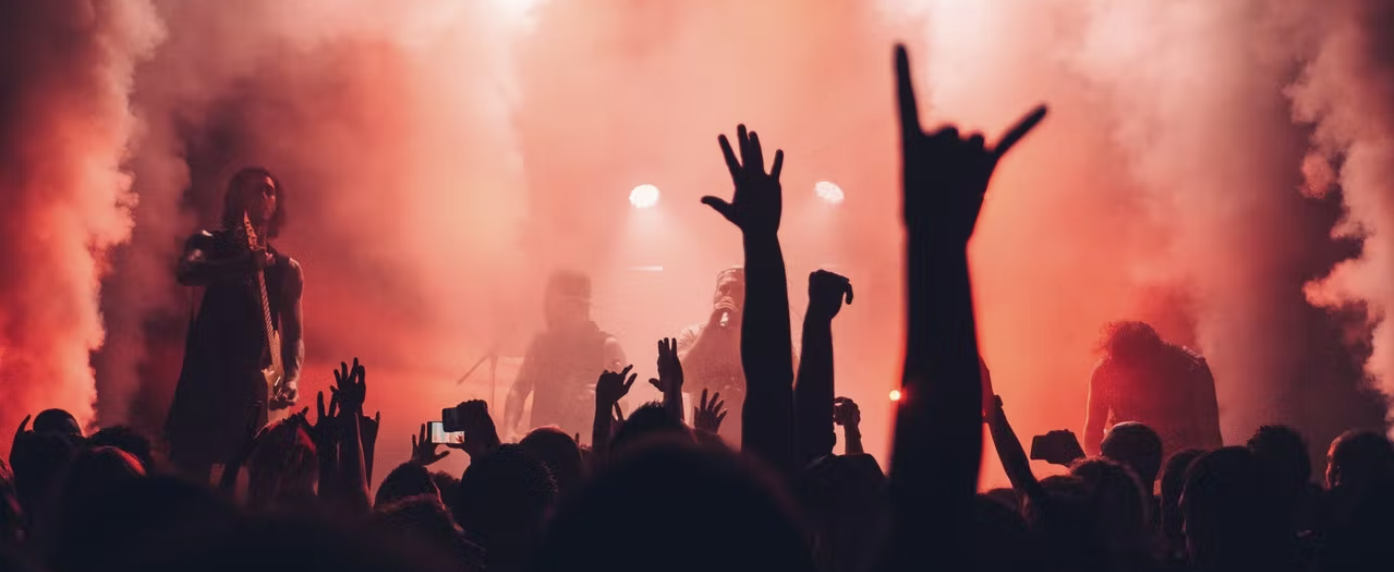

# Spotify

**Author:** Dermot O'Brien
***

## Overview

60,000 songs are uploaded to spotifys platform daily, giving spotify early access to data unseen by other interested parties. Spotify’s largest expenses come from the licencing cots paid to the major record labels that allow spotify to stream their clients music. If spotify were able to recgonize talent on their own using data only available to them, they could potentially create their own record label, sign artists with high potential, and reduce/avoid the high licensing costs paid to labels. If changing their business model is too large of a task, they can at the very least understand which songs and artists to back up with funding and team support to maximize streams and optimize resource allocation. 

## Business Problem

To ensure the success of spotify’s own label, they need to be able to instantaneously - on first upload to the database - whether or not a song will be a success. As a consultant of spotify, I will work to create a model that can be used by Spotify that recgonizes those high-potential hit songs based on spotifys own data - specifically audio features and spotify-specific features. 

## I. Data Importing and Dataframe Creation
To create the dataframe used for modeling, three steps will be required. First, I will need to pull a list of id's from Kaggle's [Every Noise at Once Dataset](https://www.kaggle.com/datasets/nikitricky/every-noise-at-once/discussion?select=songs.csv) that can pass through Spotify's API. Note that I will only be using data between January 2020 and September 2021 for relevance purposes. Next, I will pass the list of id's through spotipy's `.audio_features` method and create a features dataframe. Finally, I'll pass the list of id's through spotipy's `.tracks` method to create a popularity dataframe. After concatenating these two dataframes, we will have a comprehensive dataframe to begin our analysis. For a cleaner notebook, I've created the features and popularity dataframes in an alternate notebook.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import base64
import requests
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import MissingIndicator
import xgboost as xgb
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

### Spotify API token creation

In [2]:
# Create variables for client id and client secret to create token
cid = 'fe9b61dd4aea4998a73a7e7f095bb66a'
secret = '8544bf1566dd4f3c8b5f80f032d9617e'

In [3]:
# Spotipy authorization steps
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Dataframe Creation
To create the features and popularity dataframes, I first needed to use for loops to retreive the data since spotify's api can only pull 50-100 rows at a time depending on the method. Since the `.tracks` method's output is a messy lists of dictionaries, we'll need a nested for loop. For documentation, please refer to the *Kaggle Investigation* notebook. The final dataframe before eda and data prep, labeled df, will be a concat of popularity_df and features_df. 

In [4]:
# Pull the dataframes created in the Kaggle Investigation Notebook
popularity_df = pd.read_csv('./Data/target_df')
features_df = pd.read_csv('./Data/features_df')

In [5]:
# Drop duplicates in features_df
features_df.drop_duplicates(subset=['id'], inplace=True)

In [6]:
# Merge dataframes on id
df = pd.merge(features_df, popularity_df, on ='id')

Due to the merge, we have roughly 20,000 rows with no popularity values. We'll go ahead and drop those before EDA

In [7]:
# Check for 0 values in popularity column
df[df['popularity'] == 0].shape

(20040, 19)

In [8]:
# Drop columns from popularity column with values of 0
df = df[df.popularity != 0]

## II. Data Understanding


### Column Names and Understanding
* `danceability`: [str] Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable.
* `energy`: [float] Represents a perceptual measure of intensity and activity. A measure from 0.0 to 1.0.
* `key`: [int] The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* `loudness`: [float] The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 db.
* `mode`: [int] Modality of a track. Major is represented by 1 and minor is 0.
* `speechiness`: [float] Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* `accousticness`: [float] A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* `instrumentalness`: [float] Predicts whether a track contains no vocals. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* `liveness`: [float] Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* `valence`: [float] A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive.
* `tempo`: [float] The overall estimated tempo of a track in beats per minute (BPM).
* `type`: [str] The object type (audio_features)
* `id`: [str] The Spotify ID for the track.
* `uri`: [str] The Spotify URI for the track.
* `track_href`: [str] A link to the Web API endpoint providing full details of the track.
* `analysis_url`: [str] A URL to access the full audio analysis of this track. An access token is required to access this data.
* `duration_ms`: [int] The duration of the track in milliseconds.
* `time_signature`: [int] An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
* `popularity`: [int] The target variable. The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

Let's start by examining the data to see how it can be cleaned. Odds are we won't need all of the columns mentioned above, some having little useful information and others being descriptive and non-numeric.

In [9]:
# Check the shape of the df
df.shape

(66045, 19)

In [10]:
# Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66045 entries, 0 to 86084
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      66045 non-null  float64
 1   energy            66045 non-null  float64
 2   key               66045 non-null  int64  
 3   loudness          66045 non-null  float64
 4   mode              66045 non-null  int64  
 5   speechiness       66045 non-null  float64
 6   acousticness      66045 non-null  float64
 7   instrumentalness  66045 non-null  float64
 8   liveness          66045 non-null  float64
 9   valence           66045 non-null  float64
 10  tempo             66045 non-null  float64
 11  type              66045 non-null  object 
 12  id                66045 non-null  object 
 13  uri               66045 non-null  object 
 14  track_href        66045 non-null  object 
 15  analysis_url      66045 non-null  object 
 16  duration_ms       66045 non-null  int64 

In [11]:
# Check the statistics of numerical columns
df.describe()

danceability        energy          key      loudness          mode  \
count  66045.000000  66045.000000  66045.00000  66045.000000  66045.000000   
mean       0.595497      0.635435      5.30673     -8.567336      0.576622   
std        0.189874      0.238108      3.57791      4.925100      0.494098   
min        0.000000      0.000221      0.00000    -53.885000      0.000000   
25%        0.473000      0.487000      2.00000    -10.137000      0.000000   
50%        0.620000      0.660000      5.00000     -7.526000      1.000000   
75%        0.742000      0.828000      8.00000     -5.566000      1.000000   
max        0.985000      1.000000     11.00000      5.968000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  66045.000000  66045.000000      66045.000000  66045.000000   
mean       0.101893      0.285464          0.204847      0.183175   
std        0.098069      0.311962          0.344674      0.143367   
min        0.000000      0.000000          0.000000      0.011300   
25%        0.039100      0.015300          0.000000      0.097100   
50%        0.058700      0.155000          0.000205      0.123000   
75%        0.125000      0.496000          0.286000      0.227000   
max        0.966000      0.996000          1.000000      0.986000   

            valence         tempo   duration_ms  time_signature    popularity  
count  66045.000000  66045.000000  6.604500e+04    66045.000000  66045.000000  
mean       0.453260    122.413112  2.326026e+05        3.920282     20.846847  
std        0.253812     29.253738  9.354251e+04        0.397993     16.860289  
min        0.000000      0.000000  3.163200e+04        0.000000      1.000000  
25%        0.242000     99.889000  1.770370e+05        4.000000      5.000000  
50%        0.442000    122.016000  2.113420e+05        4.000000     17.000000  
75%        0.653000    140.070000  2.610960e+05        4.000000     33.000000  
max        0.991000    236.196000  2.441813e+06        5.000000     89.000000

### Danceability

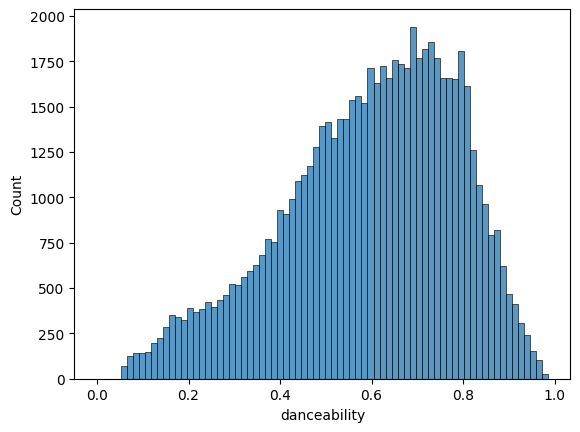

In [12]:
sns.histplot(df.danceability);

### Energy

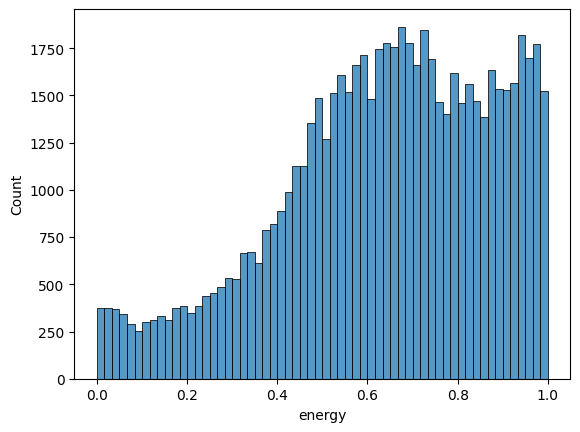

In [13]:
sns.histplot(df.energy);

### Key

In [14]:
df.key.value_counts(normalize=True, ascending=False)

1     0.115573
7     0.108971
0     0.104580
2     0.096253
9     0.095359
11    0.085260
5     0.078159
6     0.076221
4     0.075706
8     0.066440
10    0.066409
3     0.031070
Name: key, dtype: float64

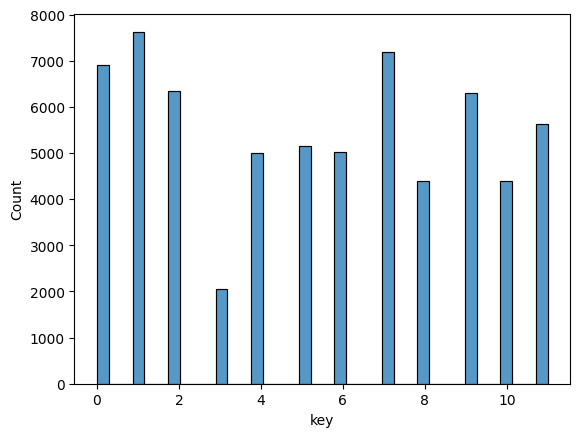

In [15]:
sns.histplot(df.key);

### Loudness

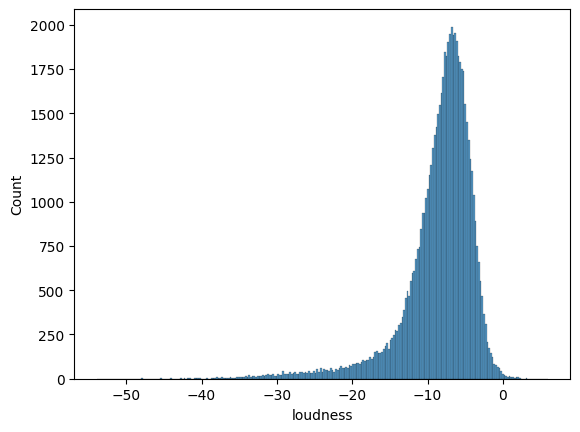

In [16]:
sns.histplot(df.loudness);

### Mode

In [17]:
# Major key = 1 and Minor key = 0
df['mode'].value_counts(normalize=True)

1    0.576622
0    0.423378
Name: mode, dtype: float64

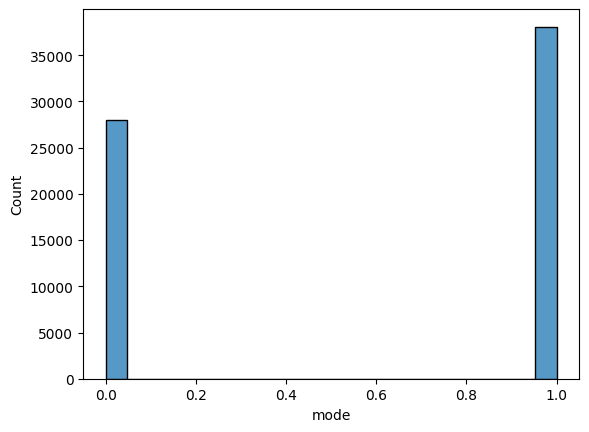

In [18]:
sns.histplot(df['mode']);

### Speechiness

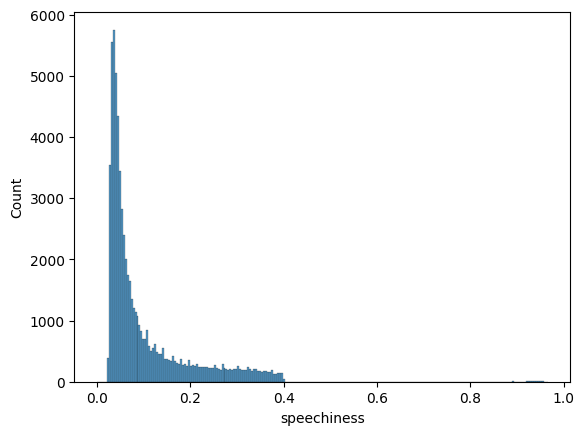

In [19]:
sns.histplot(df.speechiness);

### Acousticness

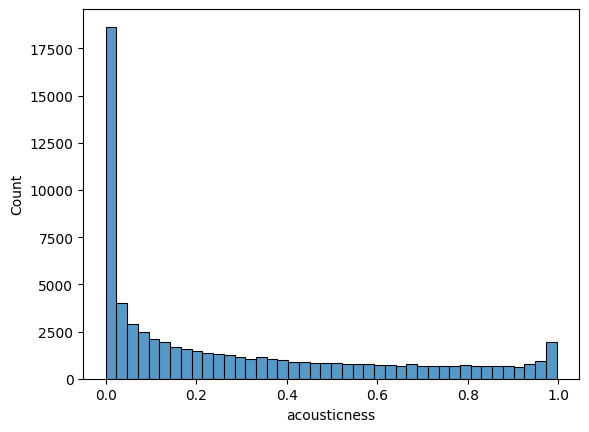

In [20]:
sns.histplot(df.acousticness);

### Instrumentalness

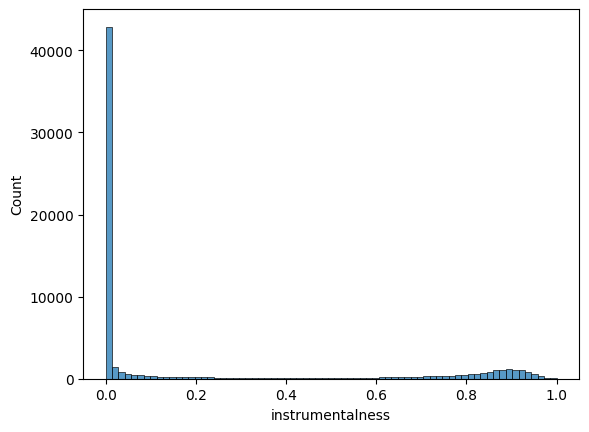

In [21]:
sns.histplot(df.instrumentalness);

### Liveness

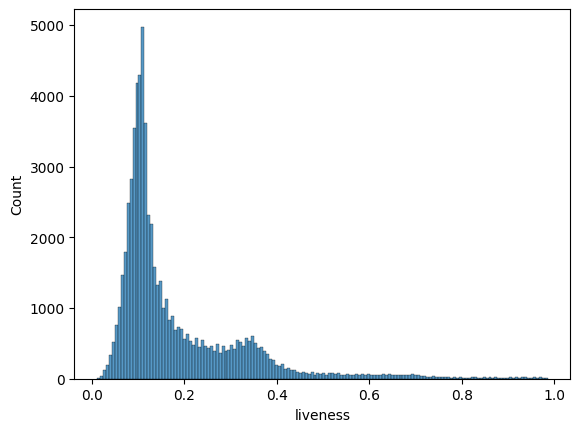

In [22]:
sns.histplot(df.liveness);

### Valence

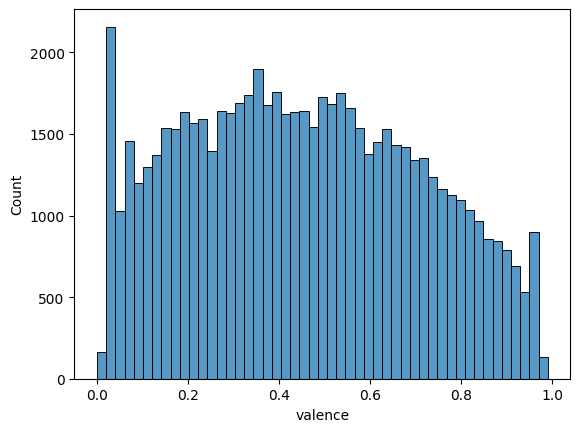

In [23]:
sns.histplot(df.valence);

### Tempo

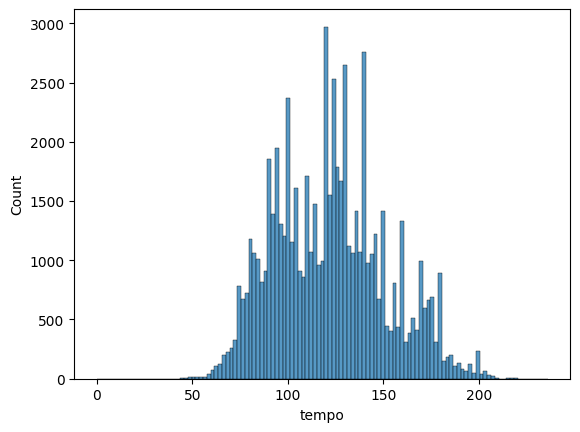

In [24]:
sns.histplot(df.tempo);

### Duration

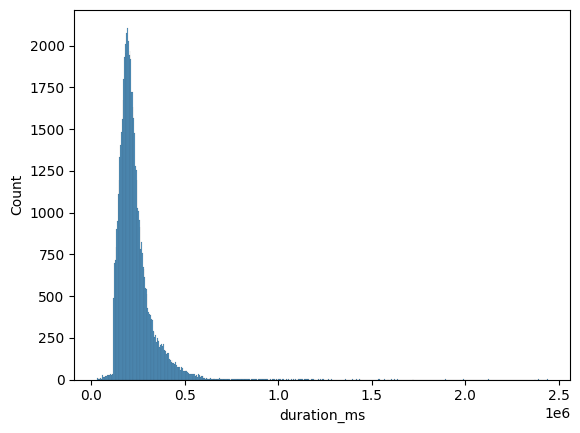

In [25]:
sns.histplot(df['duration_ms']);

### Time Signature

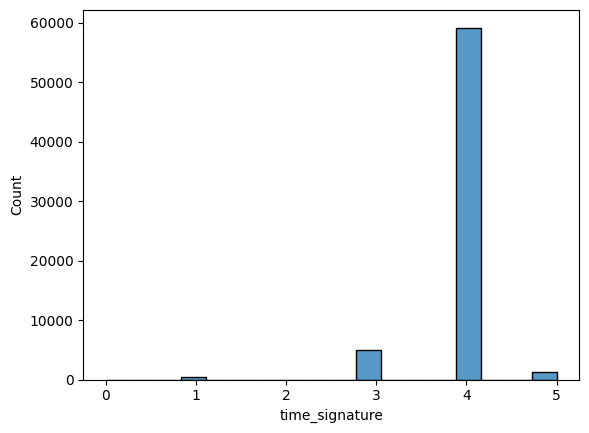

In [26]:
sns.histplot(df.time_signature);

### Popularity

In [27]:
df.popularity.value_counts(normalize=True)

1     0.085760
2     0.057582
3     0.044046
4     0.035415
5     0.029374
        ...   
84    0.000061
87    0.000045
88    0.000015
89    0.000015
86    0.000015
Name: popularity, Length: 89, dtype: float64

In [28]:
df[df['popularity'] == 1].shape

(5664, 19)

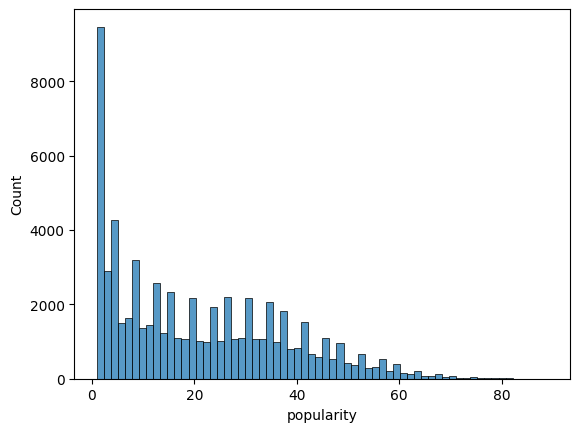

In [29]:
sns.histplot(df.popularity);

In [30]:
test_df = df[df['popularity'] > 4]

In [31]:
test_df.shape

(51330, 19)

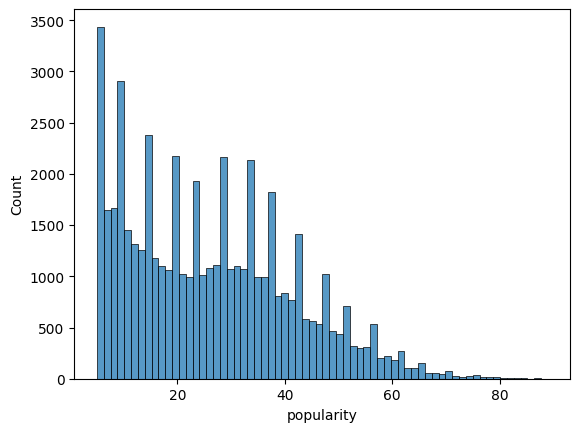

In [32]:
sns.histplot(test_df.popularity);

## III. Data Preparation
When checking the data, a common scenario occured where a song that was first released as a single and later put on an album were getting extremey low scores, possibly because spotify separates data on the single vs on an album. To ensure those album songs arent getting tracked, we will remove the very low scores, which I classified as songs with a popularity score less than 5.

We'll then need to add a binary column that indicates whether a song is a "hit" or not. This will be classified by songs with a popularity score > 50. Since were looking at older songs (Jan 2020 - Sept 2021), I lowered the threshold of popularity since the algorithim from spotify adds more weight to recent streams.

* `hit`: new column - indicates if that song is a hit or not

Let's also drop inutile columns:
* `key`: looks somewhat equally distributed
* `time_signature`: mostly all songs have a time signature of 4
* `popularity`: since we changed this to a binary (Hit or no hit), we can drop this column
* None-numeric columns to drop: `type`, `id`, `uri`, `track_href`, `analysis_url`

In [33]:
# Using drop() to delete rows based on column value
#df.drop(df[df['popularity'] < 5].index, inplace=True)

In [34]:
# Check to see if that worked, should now have 51,330 rows
df.shape

(66045, 19)

In [35]:
# Change duration_ms to duration_s, milliseconds to seconds conversion
df['duration_ms'] = df['duration_ms'].div(1000).round()

In [36]:
df.rename(columns={'duration_ms':'duration_s'}, inplace=True)

In [37]:
# Before dropping columns, make a copy of the dataframe for visuals (need popularity column)
df_radar = df.copy()

In [38]:
# Create a new column for 'hit'
df['hit'] = np.where(df['popularity'] >= 50, 1, 0)

In [39]:
# Check to see if the new column works correctly
df.loc[df['popularity'] >= 50, ['hit']].min() == df.loc[df['popularity'] >= 50, ['hit']].max()

hit    True
dtype: bool

In [40]:
df.loc[df['popularity'] < 50, ['hit']].min() == df.loc[df['popularity'] < 50, ['hit']].max()

hit    True
dtype: bool

In [41]:
# Drop inutile columns for df
df.drop(['key', 
         'time_signature', 
         'popularity', 
         'type', 
         'id', 
         'uri', 
         'track_href',
         'analysis_url'], axis=1, inplace=True)

In [42]:
# Check to see if that worked, should now have 12 columns
df.shape

(66045, 12)

### Some Visualizations

In [43]:
# Visualize distributions
#for a, column in enumerate(df.columns):
#    plt.figure(a)
#    sns.histplot(df[column])

In [44]:
# Create a scatter matrix of columns to check for correlation
#sns.pairplot(df)

#### Radar Chart (Spider Chart)

In [45]:
# Radar Chart Setup
df_radar['hit'] = np.where(df_radar['popularity'] >= 75, 1, 0)

In [46]:
# Drop inutile columns for df
df_radar.drop(['key', 
         'time_signature', 
         'popularity', 
         'type', 
         'id', 
         'uri', 
         'track_href',
         'analysis_url',
         'mode'], axis=1, inplace=True)

In [47]:
# minmax scale the data
mmscaler = MinMaxScaler()
radar_scaled = mmscaler.fit_transform(df_radar[['danceability',
                                 'energy',
                                 'loudness',
                                 'speechiness',
                                 'acousticness',
                                 'instrumentalness',
                                 'liveness',
                                 'valence',
                                 'tempo',
                                 'duration_s']])
df_radar_scaled = pd.DataFrame(radar_scaled)

In [48]:
# Rename columns
df_radar_scaled.rename(columns={0:'danceability',
                                1:'energy',
                                2:'loudness',
                                3:'speechiness',
                                4:'acousticness',
                                5:'instrumentalness',
                                6:'liveness',
                                7:'valence',
                                8:'tempo',
                                9:'duration_seconds'}, inplace=True)

In [49]:
# Add hit back
hit_column = df_radar['hit']
df_radar_scaled['hit'] = hit_column.values

In [50]:
# Create a dataframe for Hit Songs, drop Hit column
df_radar_hit = df_radar_scaled.loc[df_radar_scaled['hit'] == 1]
df_radar_hit.drop('hit', axis=1, inplace=True)

In [51]:
# Create a dataframe for Not Hit Songs, drop Hit column
df_radar_nohit = df_radar_scaled.loc[df_radar_scaled['hit'] == 0]
df_radar_nohit.drop('hit', axis=1, inplace=True)

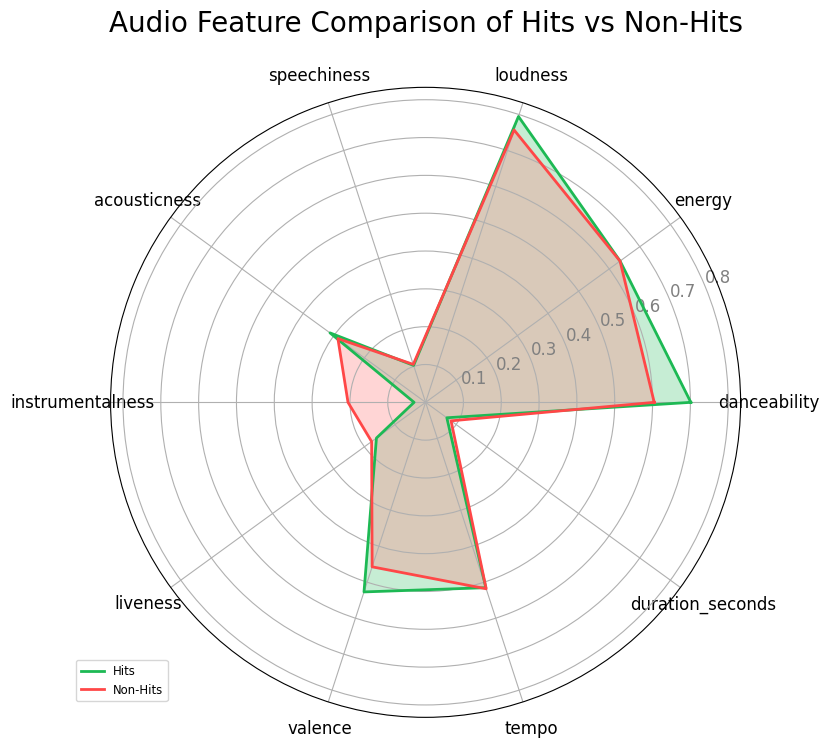

In [52]:
# Create a Radar chart using matplotlib

# Set data
# Convert column names into a list
categories = list(df_radar_hit.columns)
# number of categories
N = len(categories)

# Create a list with the average of all features
value_hit = list(df_radar_hit.mean())
value_nohit = list(df_radar_nohit.mean())

# Repeat first value to close the circle
# The plot is a circle, so we need to "complete the loop" and append the start value to the end
value_hit+=value_hit[:1]
value_nohit+=value_nohit[:1]

# Calculate angle for each category
angles=[n/float(N)*2*pi for n in range(N)]
angles+=angles[:1]

# Plot
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(221, polar=True)

#Plot 1 - Hits
ax.plot(angles, value_hit,  linewidth=2, label="Hits", color='#1DB954')
ax.fill(angles, value_hit, alpha=0.25, facecolor='#1DB954')

#Plot 2 Non-Hits
ax.plot(angles, value_nohit, linewidth=2, label = "Non-Hits", color='#ff4747')
ax.fill(angles, value_nohit, alpha=0.35, facecolor='#f88' )

ax.set_title('Audio Feature Comparison of Hits vs Non-Hits', size=20, pad=40)
ax.grid(True)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='small')

# Add axis ticks
plt.xticks(angles[:-1],categories, size=12)
ax.tick_params(axis='x', which='major', pad=10)
plt.yticks(color='grey',size=12)


# Create a color palette:
plt.cm.get_cmap("Set2", len(df_radar_hit.index))

# Dispay chart
plt.show();

# Save Figure
#plt.savefig('./Visuals/radar_chart.png')

## IV. Data Modeling
Describe and justify the process for analyzing or modeling the data.

### Modeling Techniques
As we edge closer to modeling, it is important to distinguish which evaluation metric we want to focus on maximizing.  Music labels want to maximize the ability to predict a hit song correctly. It is more important that they predict a hit correctly, opposed to missing out on a song that eventually became a hit. In this instance, precision is most important to Spotify's bottom line. Remember that precision in our context evaluates how well our model correctly predicts whether a song will be a hit or not:

Precision = True positives / (True positives + False positives)

Basically, of all of our predicted hit songs, how many were actually hit songs?

Recall measures how many actual hits we predicted correctly.

Recall = True positives / (True positives + False negatives)

If we classified a song as not a hit, but then it becomes a hit (false negative), we're not losing much monetarily given we never actually invested time/resources into that song/artist. On the other hand, if we predict a song is a hit and it ends up being a flop (false positive) we have now lost a lot of time and money on a dud. The later scenario is one that we want to minimize, which is why we are focusing on precision.

### Train Test Split

In [53]:
# Create variables and split data into training and testing
X = df.drop('hit', axis=1)
y = df['hit']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Class Setup for Model Evaluation

In [54]:
# Create a Class to evaluate each model with cross validation
# This plot was taken from flatiron school's curriculum team and adapted by our team to fit our needs

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_accuracy = None
        self.cv_precision = None
        self.cv_recall = None

        # cross validate immediately when an object is created or not
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_accuracy = cross_val_score(self.model, cv_X, cv_y, cv=kfolds).mean()
        self.cv_recall = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='recall').mean()
        self.cv_precision = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring='precision').mean()

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_accuracy: .5f} accuracy
            {self.cv_recall: .5f} recall
            {self.cv_precision: .5f} precision
        ''')
        print(cv_summary)

        return cv_summary

### Dummy Model

In [55]:
# Dummy Model that predicts all observations to be in the hit class
dummy_model_constant = DummyClassifier(strategy='constant', constant=1)
dummy_model_constant.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='constant')

In [56]:
# Evaluate dummy constant model with CV
dummy_constant_results = ModelWithCV(model=dummy_model_constant,
                         model_name='dummy_constant_results',
                         X=X_train,
                         y=y_train)

dummy_constant_results.print_cv_summary();

CV Results for `dummy_constant_results` model:
             0.06491 accuracy
             1.00000 recall
             0.06491 precision
        


In [57]:
# Dummy Model that predicts all observations to be in the class with the most frequent values (not a hit)
dummy_model_mf = DummyClassifier(strategy='most_frequent', constant=1)
dummy_model_mf.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='most_frequent')

In [58]:
# Evaluate dummy mf model with CV
dummy_mf_results = ModelWithCV(model=dummy_model_mf,
                         model_name='dummy_mf_results',
                         X=X_train,
                         y=y_train)

dummy_mf_results.print_cv_summary();

CV Results for `dummy_mf_results` model:
             0.93509 accuracy
             0.00000 recall
             0.00000 precision
        


### Pipeline Setup

Creating this pipeline will allow us to make changes in a more efficient manner, simplifying the process of itereating models and tuning individual pipelines as needed.

In [59]:
# Create pipelines for missing indicator, numeric and categorical to fit into Categorical Transformer.
num_pipeline = Pipeline(steps=[ ('ss', StandardScaler())])
cat_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [60]:
# The "remainder='passthrough'" bit tells the compiler to leave the other df columns unchanged.
CT = ColumnTransformer(transformers=[('num_pipeline', num_pipeline, 
                                          ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']),
                                     ('cat_pipeline', cat_pipeline, 
                                          ['mode'])], remainder='passthrough')

### Decision Trees

In [61]:
# Create a Decision Tree model using created pipeline
dtree_pipe = Pipeline(steps=[('ct', CT),
                             ('decisiontree', DecisionTreeClassifier())])
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('decisiontree', DecisionTreeClassifier())])

In [62]:
# Evaluate Decision Tree model with CV
dtree_results = ModelWithCV(model=dtree_pipe,
                         model_name='dtree_pipe',
                         X=X_train,
                         y=y_train)

dtree_results.print_cv_summary();

CV Results for `dtree_pipe` model:
             0.87707 accuracy
             0.14152 recall
             0.11631 precision
        


### Random Forest

In [63]:
# Create a Random Forest model using created pipeline
rfc_pipe = Pipeline(steps=[('ct', CT),
                           ('rfc', RandomForestClassifier())])
rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['mode'])])),
                ('rfc', RandomForestClassifier())])

In [64]:
# Evaluate Random Forest model with CV
rfc_results = ModelWithCV(model=rfc_pipe,
                         model_name='rfc_pipe',
                         X=X_train,
                         y=y_train)

rfc_results.print_cv_summary();

CV Results for `rfc_pipe` model:
             0.93590 accuracy
             0.02302 recall
             0.69838 precision
        


#### RF Grid Search 1

In [70]:
# Random Forest Grid Search 1
rf_grid_1 = {'rfc__max_depth': [3,5,7],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1, 2, 3],
 'rfc__min_samples_split': [2, 5, 10],
 'rfc__n_estimators': [10,100,200]}

In [71]:
# Instantiate Random Forest Grid Search 1
rf_gs_1 = GridSearchCV(estimator=rfc_pipe, 
                     param_grid=rf_grid_1, 
                     cv=5, 
                     scoring='precision',
                     verbose=2,
                     n_jobs=-2)

In [72]:
# Fit data on the Random Forest Grid Search 1
# Markdown of results below, uncomment to run
# rf_gs_1.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['mode'])])),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rfc__max_depth': [3, 5, 7],
                         'rfc__max_features': ['sqrt'],
                         'rfc__min_samples_leaf': [1, 2, 3],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [10, 100, 200]},
             scoring='precision', verbose=2)

In [75]:
# Check best params - Markdown to avoid re-running
# rf_gs_1.best_params_

rf_gs_1.best_params
* rfc__max_depth': 5
* rfc__max_features': 'sqrt'
* rfc__min_samples_leaf': 1
* rfc__min_samples_split': 2
* rfc__n_estimators': 10

In [77]:
# Check best score - Markdown to avoid re-running
# rf_gs_1.best_score_

rf_gs_1.best_score_
* 0.88333

In [78]:
# Save best estimator to run cross validation on
# rf_gs_1_best = rf_gs_1.best_estimator_

In [80]:
# Evaluate Best RF GF 1 model with CV - Markdown to avoid re-running
# rf_gf_1_results = ModelWithCV(model=rf_gs_1_best,
#                          model_name='rf_gs_1',
#                          X=X_train,
#                          y=y_train)

# rf_gf_1_results.print_cv_summary();

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.3s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.9s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   8.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.9s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=10; total time=  

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   4.6s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   8.2s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   3.9s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.1s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time= 

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   4.6s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   8.3s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   4.6s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   8.3s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   8.2s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=3, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=3, rfc__min_samples_split=2, rfc__n_estimators=200; total time=

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.2s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=100; total time=  

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.3s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.5s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   8.2s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   7.9s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=10, rfc__n_estimators=100; total time

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=100; total time=   4.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=10; total time=   0.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   8.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total tim

[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=10; total time=   0.7s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=2, rfc__n_estimators=200; total time=   8.3s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=100; total time=   3.8s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=1, rfc__min_samples_split=10, rfc__n_estimators=200; total time=   8.4s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=100; total time=   4.0s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=2, rfc__min_samples_split=5, rfc__n_estimators=200; total time=   8.2s
[CV] END rfc__max_depth=3, rfc__max_features=sqrt, rfc__min_samples_leaf=3, rfc__min_samples_split=2, rfc__n_estimators=100; total time

CV Results for `rf_gs_1` model:
* 0.93544 accuracy
* 0.00747 recall
* 0.80000 precision

#### RF Grid Search 2

In [81]:
# Random Forest Grid Search 2
rf_grid_2 = {'rfc__max_depth': [5],
 'rfc__max_features': ['sqrt'],
 'rfc__min_samples_leaf': [1],
 'rfc__min_samples_split': [1, 2],
 'rfc__n_estimators': [10, 50, 70, 100]}

In [82]:
# Instantiate Random Forest Grid Search 2
rf_gs_2 = GridSearchCV(estimator=rfc_pipe, 
                     param_grid=rf_grid_2, 
                     cv=5, 
                     scoring='precision',
                     verbose=2,
                     n_jobs=-2)

In [83]:
# Fit data on the Random Forest Grid Search 2
# Markdown of results below, uncomment to run
# rf_gs_2.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['mode'])])),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rfc__max_depth': [5], 'rfc__max_features': ['sqrt'],
                         'rfc__min_samples_leaf': [1],
                         'rfc__min_samples_split': [1, 2],
                         'rfc__n_estimators': [10, 50, 70, 100]},
             scoring='precision', verbose=2)

In [85]:
# Check best params - Markdown to avoid re-running
# rf_gs_2.best_params_

rf_gs_2.best_params
* rfc__max_depth': 5
* rfc__max_features': 'sqrt'
* rfc__min_samples_leaf': 1
* rfc__min_samples_split': 1
* rfc__n_estimators': 50

In [87]:
# Check best score - Markdown to avoid re-running
# rf_gs_2.best_score_

rf_gs_2.best_score_
* 0.90

In [88]:
# Save best estimator to run cross validation on
# rf_gs_2_best = rf_gs_2.best_estimator_

In [89]:
# Evaluate Best RF GF 1 model with CV
# rf_gf_2_results = ModelWithCV(model=rf_gs_2_best,
#                          model_name='rf_gs_2',
#                          X=X_train,
#                          y=y_train)

# rf_gf_2_results.print_cv_summary();

CV Results for `rf_gs_2` model:
             0.93544 accuracy
             0.00591 recall
             0.82500 precision
        


CV Results for `rf_gs_2` model:
* 0.93544 accuracy
* 0.00591 recall
* 0.82500 precision

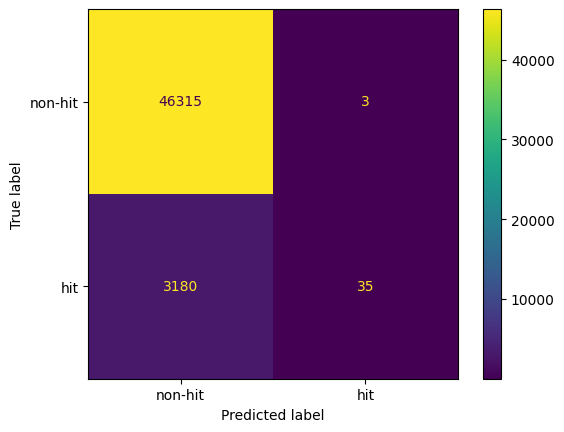

In [99]:
# Plot confusion matrix
# ConfusionMatrixDisplay.from_estimator(rf_gs_2, X_train, y_train, display_labels=['non-hit', 'hit']);

### XGBoost

In [119]:
# Create a XGBoost model using created pipeline
xgb_pipe = Pipeline(steps=[('ct', CT),
                           ('xgb', xgb.XGBClassifier(objective='binary:logistic'))])
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=Fa...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [120]:
# Evaluate XGBoost model with CV
xgb_results = ModelWithCV(model=xgb_pipe,
                         model_name='xgb_pipe',
                         X=X_train,
                         y=y_train)

xgb_results.print_cv_summary();

CV Results for `xgb_pipe` model:
             0.93509 accuracy
             0.03079 recall
             0.49662 precision
        


#### XGBoost Grid Search 1

In [124]:
# XGBoost Grid Search 1
xgb_param_grid_1 = {'xgb__max_depth': [3,4,5],
                    'xgb__learning_rate': [.1,.01,.05],
                    'xgb__gamma' : [0,.25,1], #encourages pruning
                    'xgb__reg_lambda': [0,1,10], #regularization param
                    'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class}

In [125]:
# Instantiate XGBoost Grid Search 1
xgb_gs_1 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_1, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [126]:
# Fit data on the XGBoost Grid Search 1
# Markdown of results below, uncomment to run
# xgb_gs_1.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anac

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handl...
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0, ...))]),
             n_jobs=-2,
             param_grid={'xgb__gamma': [0, 0.25, 1],
                         'xgb__learning_rate': [0.1, 0.01, 0.05],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__reg_lambda': [0, 1, 10],
                         'xgb__scale_pos_weight': [1, 3, 5]},
             scoring='precision', verbose=3)

In [133]:
# Check best params - Markdown to avoid re-running
# xgb_gs_1.best_params_

xgb_gs_1.best_params_
* 'xgb__gamma': 0,
* 'xgb__learning_rate': 0.01,
* 'xgb__max_depth': 4,
* 'xgb__reg_lambda': 10,
* 'xgb__scale_pos_weight': 1}

In [134]:
# Check best score - Markdown to avoid re-running
# xgb_gs_1.best_score_

xgb_gs_1.best_score_
* xgb_gs_1.best_score_

In [131]:
# Save best estimator to run cross validation on
# xgb_gs_1_best = xgb_gs_1.best_estimator_

In [132]:
# Evaluate Best XGBoost Grid Search 1 model with CV
# xgb_gs_1_results = ModelWithCV(model=xgb_gs_1_best,
#                          model_name='xgb_gs_1',
#                          X=X_train,
#                          y=y_train)

# xgb_gs_1_results.print_cv_summary();

CV Results for `rf_gs_2` model:
             0.93588 accuracy
             0.01524 recall
             0.81156 precision
        


CV Results for `rf_gs_2` model:
* 0.93588 accuracy
* 0.01524 recall
* 0.81156 precision

#### XGBoost Grid Search 2

In [135]:
# XGBoost Grid Search 2
xgb_param_grid_2 = {'xgb__max_depth': [4],
                    'xgb__learning_rate': [.01],
                    'xgb__gamma' : [0], #encourages pruning
                    'xgb__reg_lambda': [10, 15, 20, 30], #regularization param
                    'xgb__scale_pos_weight': [.5, 1]} #penalty on choosing incorrect class

In [136]:
# Instantiate XGBoost Grid Search 2
xgb_gs_2 = GridSearchCV(estimator=xgb_pipe, 
                      param_grid=xgb_param_grid_2, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [137]:
# Fit data on the XGBoost Grid Search 2
# Markdown of results below, uncomment to run
# xgb_gs_2.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handl...
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0, ...))]),
             n_jobs=-2,
             param_grid={'xgb__gamma': [0], 'xgb__learning_rate': [0.01],
                         'xgb__max_depth': [4],
                         'xgb__reg_lambda': [10, 15, 20, 30],
                         'xgb__scale_pos_weight': [0.5, 1]},
             scoring='precision', verbose=3)

In [138]:
# Check best params - Markdown to avoid re-running
# xgb_gs_2.best_params_

{'xgb__gamma': 0,
 'xgb__learning_rate': 0.01,
 'xgb__max_depth': 4,
 'xgb__reg_lambda': 15,
 'xgb__scale_pos_weight': 1}

xgb_gs_2.best_params_
* 'xgb__gamma': 0,
* 'xgb__learning_rate': 0.01,
* 'xgb__max_depth': 4,
* 'xgb__reg_lambda': 15,
* 'xgb__scale_pos_weight': 1}

In [139]:
# Check best score - Markdown to avoid re-running
# xgb_gs_2.best_score_

0.8421153846153846

xgb_gs_2.best_score_
* 0.8421153846153846

In [140]:
# Save best estimator to run cross validation on
# xgb_gs_2_best = xgb_gs_2.best_estimator_

In [141]:
# Evaluate Best XGBoost Grid Search 1 model with CV
# xgb_gs_2_results = ModelWithCV(model=xgb_gs_2_best,
#                          model_name='xgb_gs_2',
#                          X=X_train,
#                          y=y_train)

# xgb_gs_2_results.print_cv_summary();

CV Results for `xgb_gs_2` model:
             0.93592 accuracy
             0.01586 recall
             0.84212 precision
        
[CV 3/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.923 total time=   5.2s
[CV 4/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=15, xgb__scale_pos_weight=1;, score=1.000 total time=   5.6s
[CV 2/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=30, xgb__scale_pos_weight=0.5;, score=0.500 total time=   4.8s
[CV 5/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=0.5;, score=0.833 total time=   4.7s
[CV 1/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=15, xgb__scale_pos_weight=1;, score=0.938 total time=   5.6s
[CV 4/5] END xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=20, xgb__scale_pos_weight=1;, score=1.000 to

CV Results for `xgb_gs_2` model:
* 0.93592 accuracy
* 0.01586 recall
* 0.84212 precision

### SMOTE

In [153]:
# Create a pipeline that includes SMOTE
smote_xgb_pipe = ImPipeline(steps=[('ct', CT),
                                 ('sm', SMOTE()),
                                 ('xgb', xgb.XGBClassifier(objective='binary:logistic'))])

In [162]:
# Evaluate XGBoost model with CV
smote_xgb_results = ModelWithCV(model=smote_xgb_pipe,
                         model_name='smote_xgb_pipe',
                         X=X_train,
                         y=y_train)

smote_xgb_results.print_cv_summary();

CV Results for `smote_xgb_pipe` model:
             0.81479 accuracy
             0.31944 recall
             0.12640 precision
        


#### XGBoost with SMOTE

In [161]:
smote_xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_s']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=Fa...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

First impression is that SMOTE is not helping our model in this instance.Let's try a comprehensive Grid Search to see if it improves. There are cases where SMOTE can hurt a model, so we wil evaluate after our Grid Search whether or not to use it for our final model.

#### XGBoost/SMOTE Grid Search

In [166]:
# Create a XGBoost/SMOTE Grid Search
smote_xgb_param_grid_1 = {'sm__k_neighbors': [3, 5, 9],
                          'sm__sampling_strategy': ['auto', .8, .9],
                          'xgb__max_depth': [3,4,5],
                          'xgb__learning_rate': [.1,.01,.05],
                          'xgb__gamma' : [0,.25,1], #encourages pruning
                          'xgb__reg_lambda': [0,1,10], #regularization param
                          'xgb__scale_pos_weight': [1,3,5]} #penalty on choosing incorrect class}

In [167]:
# Instantiate XGBoost/SMOTE Grid Search
smote_xgb_gs_1 = GridSearchCV(estimator=smote_xgb_pipe, 
                      param_grid=smote_xgb_param_grid_1, 
                      cv=5,
                      scoring='precision',
                      verbose=3,
                      n_jobs=-2)

In [168]:
# Fit data on the XGBoost Grid Search
# smote_xgb_gs_1.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.089 total time=  10.9s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.113 total time=  11.4s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.085 total time=  11.6s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.088 total time=  11.2s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.117 total time=  17.1s
[CV 2/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


scale_pos_weight=3;, score=0.082 total time=  17.7s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.093 total time=  18.2s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.078 total time=  23.2s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.083 total time=  26.6s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.083 total time=  21.3s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.098

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.114 total time=  10.9s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.083 total time=  11.5s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.081 total time=  11.5s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.106 total time=  11.2s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.082 total time=  12.8s
[CV 1/5] END sm__k_neighbors=3, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.114 total time=  10.9s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.081 total time=  11.7s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.112 total time=  11.5s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.087 total time=  11.2s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.117 total time=  17.1s
[CV 4/5] END sm__k_neighbors=3, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.087 total time=  11.0s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.090 total time=  11.5s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.082 total time=  11.6s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.083 total time=  11.2s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.112 total time=  17.2s
[CV 2/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.087 total time=  11.0s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.108 total time=  11.6s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.114 total time=  11.6s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.082 total time=  11.2s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.093 total time=  17.3s
[CV 5/5] END sm__k_neighbors=3, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.110 total time=  10.9s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.083 total time=  11.5s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.088 total time=  11.7s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.088 total time=  11.3s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.091 total time=  17.4s
[CV 1/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.087 total time=  10.9s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.113 total time=  11.4s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.087 total time=  11.8s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.083 total time=  11.3s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.090 total time=  17.2s
[CV 3/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.111 total time=  10.9s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.082 total time=  11.6s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.082 total time=  11.6s
[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.088 total time=  11.3s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.094 total time=  17.3s
[CV 4/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.089 total time=  19.5s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.095 total time=  19.8s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.097 total time=  11.8s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.076 total time=  11.7s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.081 total time=  11.8s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.108 total time=  10.9s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.113 total time=  11.4s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.087 total time=  11.5s
[CV 4/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.115 total time=  11.2s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.113 total time=  17.2s
[CV 5/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.083 total time=  10.8s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.111 total time=  11.5s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.082 total time=  11.6s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.087 total time=  11.2s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.116 total time=  17.1s
[CV 3/5] END sm__k_neighbors=3, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 5/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.088 total time=  11.0s
[CV 1/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.087 total time=  11.5s
[CV 2/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.113 total time=  11.6s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.081 total time=  11.2s
[CV 3/5] END sm__k_neighbors=3, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.091 total time=  17.1s
[CV 1/5] END sm__k_neighbors=3, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.116 total time=  13.1s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.082 total time=  12.9s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.087 total time=  16.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.091 total time=  16.9s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.117 total time=  16.5s
[CV 3/5] END sm__k_neighbors=5, sm__s

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


a=0.25, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.115 total time=  16.5s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.087 total time=  17.4s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.093 total time=  21.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.124 total time=  22.7s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.089 total time=  22.7s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_r

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.082 total time=  13.5s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.091 total time=  13.5s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.115 total time=  13.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.121 total time=  17.0s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.087 total time=  17.3s
[CV 3/5] END sm__k_neigh

[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.094 total time=  10.5s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.079 total time=  10.8s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.081 total time=  10.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.101 total time=  14.4s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.078 total time=  14.3s
[CV 1/5] END sm__k_neighbors=5, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.088 total time=  12.8s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.113 total time=  13.4s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.081 total time=  12.9s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.092 total time=  16.4s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.112 total time=  16.8s
[CV 1/5] END sm__k_neighbors=5, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


mpling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.113 total time=  16.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.086 total time=  17.2s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.093 total time=  22.1s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.122 total time=  22.5s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.089 total time=  22.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xg

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.127 total time=  20.6s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.092 total time=  20.0s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.096 total time=  21.3s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.082 total time=  11.8s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.101 total time=  12.0s
[CV 2/5] END sm__k_neighbors=5, sm__sampli

[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.103 total time= 1.0min
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.078 total time=  59.9s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.081 total time= 1.3min
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.085 total time= 1.3min
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.101 total time= 1.4min
[CV 4/5] END sm__k_nei

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.119 total time=  17.4s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.086 total time=  16.6s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.085 total time=  17.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.092 total time=  16.3s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.117 total time=  21.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learn

[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.092 total time=  19.6s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.120 total time=  26.4s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.090 total time=  25.8s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.093 total time=  23.6s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.094 total time=  24.2s
[CV 2/5] END sm__k_neighbors=5, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.087 total time=  14.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.094 total time=  14.7s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.117 total time=  14.3s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.087 total time=  14.0s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.095 total time=  18.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, x

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.115 total time=  17.2s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.086 total time=  16.6s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.093 total time=  17.2s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.090 total time=  16.4s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.118 total time=  21.7s
[CV 3/5] END sm__k_neighbors=5, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


pling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.087 total time=  22.4s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.095 total time=  22.9s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.113 total time=  21.9s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.094 total time=  13.9s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.080 total time=  12.9s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xg

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


e=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.118 total time=  18.0s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.119 total time=  17.9s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.091 total time=  17.6s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.081 total time=  10.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.098 total time=  10.8s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.118 total time=  16.5s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.084 total time=  17.1s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.090 total time=  16.3s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.123 total time=  21.8s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.089 total time=  22.4s
[CV 1/5] END sm__k_neighbors=5, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


e=0.084 total time=  14.3s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.088 total time=  21.4s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.111 total time=  21.0s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.082 total time=  20.6s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.088 total time=  21.1s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.107 total time=  24.4s
[CV 1/5

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0, xgb__scale_pos_weight=5;, score=0.090 total time=  20.0s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.098 total time=  12.2s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.080 total time=  12.3s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.080 total time=  12.2s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.085 total time=  16.3s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.11

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


bda=1, xgb__scale_pos_weight=3;, score=0.090 total time=  10.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.123 total time=  10.9s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.084 total time=  11.9s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.096 total time=  15.1s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.122 total time=  15.8s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weigh

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


me=  18.8s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.083 total time=  24.6s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.085 total time=  21.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.112 total time=  19.2s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.082 total time=  18.9s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.085 total time=  24.7s
[CV 2/5

[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.081 total time=  22.4s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.085 total time=  21.1s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.115 total time=  12.9s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.081 total time=  12.9s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.087 total time=  12.8s
[CV 5/5] END sm__k_neighbors=5, sm__sam

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.114 total time= 1.3min
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.086 total time= 1.3min
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.082 total time=  46.4s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.088 total time=  45.2s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.121 total time=  45.2s
[CV 5/5] END sm__k_neighbors=5,

[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.097 total time=  13.9s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.076 total time=  13.0s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.081 total time=  12.8s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.090 total time=  12.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.094 total time=  17.2s
[CV 2/5] END sm__k_neighbors=5, sm

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


18.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.102 total time=  17.8s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.120 total time=  17.1s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.092 total time=  17.2s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.079 total time=  10.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.084 total time=  10.8s
[CV 3/5] END sm__k_n

[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.080 total time= 1.3min
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.114 total time=  45.9s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.080 total time=  45.1s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.080 total time=  44.5s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.090 total time= 1.0min
[CV 3/5] END sm__k_neig

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.090 total time=  16.4s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.120 total time=  16.8s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.086 total time=  17.1s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.087 total time=  16.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.097 total time=  22.2s
[CV 3/5] END sm__k_neighbors=5, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


gb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.121 total time=  10.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.086 total time=  10.2s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.090 total time=   9.9s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.126 total time=  13.6s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.089 total time=  13.5s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, 

[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.079 total time= 1.0min
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.084 total time= 1.3min
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.083 total time= 1.3min
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.103 total time= 1.3min
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.079 total time= 1.3min
[CV 4/5] END sm__k_neighbors=5, sm__s

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.091 total time=  16.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.092 total time=  17.0s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.117 total time=  16.8s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.085 total time=  16.9s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.094 total time=  22.1s
[CV 1/5] END sm__k_neighbors=5, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


110 total time=  20.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.083 total time=  21.8s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.086 total time=  20.3s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.112 total time=  21.4s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.081 total time=  19.7s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.085 total time=  24.6s
[CV 2/5] E

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.089 total time=  17.3s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.118 total time=  16.3s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.119 total time=  21.6s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.090 total time=  22.4s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.094 total time=  23.1s
[CV 4/5] END sm__k_neighbors=5, sm__sam

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


b__scale_pos_weight=5;, score=0.078 total time=  12.0s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.079 total time=  12.3s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.083 total time=  11.9s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.107 total time=  16.0s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.080 total time=  19.4s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.082 tot

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.118 total time=  17.3s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.085 total time=  16.6s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.092 total time=  17.1s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.113 total time=  16.3s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.085 total time=  17.2s
[CV 1/5] END sm__k_neighbors=5, sm__sa

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.091 total time=  22.7s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.092 total time=  22.1s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.118 total time=  22.3s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=5;, score=0.088 total time=  21.8s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.093 total time=  14.1s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=0.25, xgb__learn

[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=auto, xgb__gamma=1, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.090 total time=  26.4s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.122 total time=  13.1s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.086 total time=  12.2s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.089 total time=  11.7s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=1;, score=0.126 total time=  13.5s
[CV 5/5] END sm__k_neighbors=5, sm__sampl

[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.119 total time=  13.7s
[CV 4/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=0, xgb__scale_pos_weight=5;, score=0.085 total time=  13.5s
[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=1, xgb__scale_pos_weight=3;, score=0.090 total time=  13.4s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.088 total time=  13.2s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.8, xgb__gamma=0.25, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__reg_lambda=0, xgb__scale_pos_weight=1;, score=0.121 total time=  16.9s
[CV 3/5] END sm__k_neigh

[CV 5/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.094 total time= 1.3min
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=0, xgb__scale_pos_weight=3;, score=0.081 total time=  46.1s
[CV 1/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=1;, score=0.096 total time=  45.2s
[CV 2/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=1, xgb__scale_pos_weight=5;, score=0.079 total time=  45.2s
[CV 3/5] END sm__k_neighbors=5, sm__sampling_strategy=0.9, xgb__gamma=0.25, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__reg_lambda=10, xgb__scale_pos_weight=3;, score=0.081 total time=  43.8s
[CV 4/5] END sm__k_neigh

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/dermotobrien/opt/anaconda3/envs/streamlit_

/Users/dermotobrien/opt/anaconda3/envs/streamlit_capstone/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_s']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handl...
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0, ...))]),
             n_jobs=-2,
             param_grid={'sm__k_neighbors': [3, 5, 9],
                         'sm__sampling_strategy': ['auto', 0.8, 0.9],
                         'xgb__gamma': [0, 0.25, 1],
                         'xgb__learning_rate': [0.1, 0.01, 0.05],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__reg_lambda': [0, 1, 10],
                         'xgb__scale_pos_weight': [1, 3, 5]},
             scoring='precision', verbose=3)

In [169]:
# Check best params - Markdown to avoid re-running
# smote_xgb_gs_1.best_params_

{'sm__k_neighbors': 5,
 'sm__sampling_strategy': 0.8,
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__reg_lambda': 0,
 'xgb__scale_pos_weight': 1}

smote_xgb_gs_1.best_params_
* 'sm__k_neighbors': 5,
* 'sm__sampling_strategy': 0.8,
* 'xgb__gamma': .25,
* 'xgb__learning_rate': 0.01,
* 'xgb__max_depth': 5,
* 'xgb__reg_lambda': 0,
* 'xgb__scale_pos_weight': 1

In [170]:
# Check best score - Markdown to avoid re-running
# smote_xgb_gs_1.best_score_

0.12707865813790303

smote_xgb_gs_1.best_score_
* 0.12707865813790303

In [171]:
# Save best estimator to run cross validation on
# smote_xgb_gs_1_best = smote_xgb_gs_1.best_estimator_

In [173]:
# Evaluate Best XGBoost/SMOTE Grid Search model with CV
# smote_xgb_gs_1_results = ModelWithCV(model=smote_xgb_gs_1_best,
#                          model_name='smote_xgb_gs_1',
#                          X=X_train,
#                          y=y_train)

# smote_xgb_gs_1_results.print_cv_summary();

CV Results for `smote_xgb_gs_1` model:
             0.76085 accuracy
             0.45443 recall
             0.12529 precision
        


CV Results for `smote_xgb_gs_1` model:
* 0.76085 accuracy
* 0.45443 recall
* 0.12529 precision

Woaaaah, that's low.

## V. Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## VI. Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***